## Optimised diffusion models 1D
Notebook created by Frédéric Charbonnier & Joel Clerc as part of the Master IS research project "Learning to generate
molecules".  
This notebook uses [Phil Wang's GitHub](https://github.com/lucidrains/denoising-diffusion-pytorch) to implement a conditional and unconditional DDMPs.
Inspired by [Nathan C. Frey's Tutorial](https://ncfrey.github.io/).

### Diffusion model 1D with classifier guidance

In [1]:
# code from https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/denoising_diffusion_pytorch_1d.py
# Classifier guidance added (inspired by https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/classifier_free_guidance.py)

import math
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum, Tensor
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from accelerate import Accelerator
from ema_pytorch import EMA

from tqdm.auto import tqdm

from denoising_diffusion_pytorch.version import __version__

# constants

ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

# helpers functions

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# classifier free guidance functions

def uniform(shape, device):
    return torch.zeros(shape, device = device).float().uniform_(0, 1)

def prob_mask_like(shape, prob, device):
    if prob == 1:
        return torch.ones(shape, device = device, dtype = torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device = device, dtype = torch.bool)
    else:
        return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob

# small helper modules

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv1d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv1d(dim, default(dim_out, dim), 4, 2, 1)

class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * (x.shape[1] ** 0.5)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = RMSNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# sinusoidal positional embeds

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class RandomOrLearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with random (learned optional) sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv1d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, classes_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(int(time_emb_dim) + int(classes_emb_dim), dim_out * 2)
        ) if exists(time_emb_dim) or exists(classes_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv1d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None, class_emb = None):

        scale_shift = None
        #if exists(self.mlp) and exists(time_emb):
        #    time_emb = self.mlp(time_emb)
        #    time_emb = rearrange(time_emb, 'b c -> b c 1')
        #    scale_shift = time_emb.chunk(2, dim = 1)
        
        if exists(self.mlp) and (exists(time_emb) or exists(class_emb)):
            cond_emb = tuple(filter(exists, (time_emb, class_emb)))
            cond_emb = torch.cat(cond_emb, dim = -1)
            cond_emb = self.mlp(cond_emb)
            cond_emb = rearrange(cond_emb, 'b c -> b c 1')
            scale_shift = cond_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv1d(hidden_dim, dim, 1),
            RMSNorm(dim)
        )

    def forward(self, x):
        b, c, n = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) n -> b h c n', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale        

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c n -> b (h c) n', h = self.heads)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv1d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, n = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) n -> b h c n', h = self.heads), qkv)

        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b (h d) n')
        return self.to_out(out)

# model

class Unet1D(nn.Module):
    def __init__(
        self,
        dim,
        num_classes,
        cond_drop_prob = 0.5,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        self_condition = False,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
        sinusoidal_pos_emb_theta = 10000,
        attn_dim_head = 32,
        attn_heads = 4
    ):
        super().__init__()

        # classifier free guidance stuff

        self.cond_drop_prob = cond_drop_prob

        # determine dimensions

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv1d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim, theta = sinusoidal_pos_emb_theta)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

         # class embeddings

        self.classes_emb = nn.Embedding(num_classes, dim)
        self.null_classes_emb = nn.Parameter(torch.randn(dim))

        classes_dim = dim * 4

        self.classes_mlp = nn.Sequential(
            nn.Linear(dim, classes_dim),
            nn.GELU(),
            nn.Linear(classes_dim, classes_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv1d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim, dim_head = attn_dim_head, heads = attn_heads)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim, classes_emb_dim = classes_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv1d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim, classes_emb_dim = classes_dim)
        self.final_conv = nn.Conv1d(dim, self.out_dim, 1)
    
    def forward_with_cond_scale(
        self,
        *args,
        cond_scale = 1.,
        rescaled_phi = 0.,
        **kwargs
    ):
        logits = self.forward(*args, cond_drop_prob = 0., **kwargs)

        if cond_scale == 1:
            return logits

        null_logits = self.forward(*args, cond_drop_prob = 1., **kwargs)
        scaled_logits = null_logits + (logits - null_logits) * cond_scale

        if rescaled_phi == 0.:
            return scaled_logits

        std_fn = partial(torch.std, dim = tuple(range(1, scaled_logits.ndim)), keepdim = True)
        rescaled_logits = scaled_logits * (std_fn(logits) / std_fn(scaled_logits))

        return rescaled_logits * rescaled_phi + scaled_logits * (1. - rescaled_phi)

    def forward(
            self, 
            x, 
            time, 
            classes,
            cond_drop_prob = None,
            x_self_cond = None):
        
        batch, device = x.shape[0], x.device

        cond_drop_prob = default(cond_drop_prob, self.cond_drop_prob)

        # derive condition, with condition dropout for classifier free guidance        

        classes_emb = self.classes_emb(classes)

        if cond_drop_prob > 0:
            keep_mask = prob_mask_like((batch,), 1 - cond_drop_prob, device = device)
            null_classes_emb = repeat(self.null_classes_emb, 'd -> b d', b = batch)

            classes_emb = torch.where(
                rearrange(keep_mask, 'b -> b 1'),
                classes_emb,
                null_classes_emb
            )

        c = self.classes_mlp(classes_emb)

        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim = 1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t, c)
            h.append(x)

            x = block2(x, t, c)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t, c)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, c)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t, c)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t, c)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t, c)
        return self.final_conv(x)

# gaussian diffusion trainer class

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

class GaussianDiffusion1D(nn.Module):
    def __init__(
        self,
        model,
        *,
        seq_length,
        timesteps = 1000,
        sampling_timesteps = None,
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        ddim_sampling_eta = 0.,
        auto_normalize = True
    ):
        super().__init__()
        self.model = model
        self.channels = self.model.channels
        self.self_condition = self.model.self_condition

        self.seq_length = seq_length

        self.objective = objective

        assert objective in {'pred_noise', 'pred_x0', 'pred_v'}, 'objective must be either pred_noise (predict noise) or pred_x0 (predict image start) or pred_v (predict v [v-parameterization as defined in appendix D of progressive distillation paper, used in imagen-video successfully])'

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        # sampling related parameters

        self.sampling_timesteps = default(sampling_timesteps, timesteps) # default num sampling timesteps to number of timesteps at training

        assert self.sampling_timesteps <= timesteps
        self.is_ddim_sampling = self.sampling_timesteps < timesteps
        self.ddim_sampling_eta = ddim_sampling_eta

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # calculate loss weight

        snr = alphas_cumprod / (1 - alphas_cumprod)

        if objective == 'pred_noise':
            loss_weight = torch.ones_like(snr)
        elif objective == 'pred_x0':
            loss_weight = snr
        elif objective == 'pred_v':
            loss_weight = snr / (snr + 1)

        register_buffer('loss_weight', loss_weight)

        # whether to autonormalize

        self.normalize = normalize_to_neg_one_to_one if auto_normalize else identity
        self.unnormalize = unnormalize_to_zero_to_one if auto_normalize else identity

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def predict_v(self, x_start, t, noise):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * noise -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * x_start
        )

    def predict_start_from_v(self, x_t, t, v):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * v
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, classes, cond_scale = 6., rescaled_phi = 0.7, x_self_cond = None, clip_x_start = False, rederive_pred_noise = False):
        #model_output = self.model(x, t, x_self_cond)
        model_output = self.model.forward_with_cond_scale(x, t, classes, cond_scale = cond_scale, rescaled_phi = rescaled_phi)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        if self.objective == 'pred_noise':
            pred_noise = model_output
            x_start = self.predict_start_from_noise(x, t, pred_noise)
            x_start = maybe_clip(x_start)

            if clip_x_start and rederive_pred_noise:
                pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_x0':
            x_start = model_output
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_v':
            v = model_output
            x_start = self.predict_start_from_v(x, t, v)
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return ModelPrediction(pred_noise, x_start)

    def p_mean_variance(self, x, t, classes, cond_scale, rescaled_phi, x_self_cond = None, clip_denoised = True):
        #preds = self.model_predictions(x, t, x_self_cond)
        preds = self.model_predictions(x, t, classes, cond_scale, rescaled_phi)
        x_start = preds.pred_x_start

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, x, t: int, classes, cond_scale = 6., rescaled_phi = 0.7, x_self_cond = None, clip_denoised = True):
        b, *_, device = *x.shape, x.device
        batched_times = torch.full((b,), t, device = x.device, dtype = torch.long)
        #model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, x_self_cond = x_self_cond, clip_denoised = clip_denoised)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, classes = classes, cond_scale = cond_scale, rescaled_phi = rescaled_phi, x_self_cond = x_self_cond, clip_denoised = clip_denoised)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.no_grad()
    def p_sample_loop(self, classes, shape, cond_scale = 6., rescaled_phi = 0.7):
        batch, device = shape[0], self.betas.device

        img = torch.randn(shape, device=device)

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            self_cond = x_start if self.self_condition else None
            #img, x_start = self.p_sample(img, t, self_cond)
            img, x_start = self.p_sample(img, t, classes, cond_scale, rescaled_phi, self_cond)

        img = self.unnormalize(img)
        return img

    @torch.no_grad()
    def ddim_sample(self, classes, shape, cond_scale = 6., rescaled_phi = 0.7, clip_denoised = True):
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.betas.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device=device, dtype=torch.long)
            self_cond = x_start if self.self_condition else None
            #pred_noise, x_start, *_ = self.model_predictions(img, time_cond, self_cond, clip_x_start = clip_denoised)
            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, classes, cond_scale = cond_scale, rescaled_phi = rescaled_phi, x_self_cond=self_cond, clip_x_start = clip_denoised)


            if time_next < 0:
                img = x_start
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

        img = self.unnormalize(img)
        return img

    @torch.no_grad()
    #def sample(self, classes, cond_scale = 6., rescaled_phi = 0.7, batch_size = 16):
    def sample(self, classes, cond_scale = 6., rescaled_phi = 0.7):
        batch_size, seq_length, channels = classes.shape[0], self.seq_length, self.channels
        sample_fn = self.p_sample_loop if not self.is_ddim_sampling else self.ddim_sample
        return sample_fn(classes, (batch_size, channels, seq_length), cond_scale, rescaled_phi)

    @torch.no_grad()
    def interpolate(self, x1, x2, classes, t = None, lam = 0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.full((b,), t, device = device)
        xt1, xt2 = map(lambda x: self.q_sample(x, t = t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2

        x_start = None

        for i in tqdm(reversed(range(0, t)), desc = 'interpolation sample time step', total = t):
            self_cond = x_start if self.self_condition else None
            img, x_start = self.p_sample(img, i, classes, self_cond)

        return img

    @autocast(enabled = False)
    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, classes, noise = None):
        b, c, n = x_start.shape
        #b, n = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly

        x_self_cond = None
        if self.self_condition and random() < 0.5:
            with torch.no_grad():
                x_self_cond = self.model_predictions(x, t).pred_x_start
                x_self_cond.detach_()

        # predict and take gradient step

        #model_out = self.model(x, t, x_self_cond)
        model_out = self.model(x, t, classes, x_self_cond)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        elif self.objective == 'pred_v':
            v = self.predict_v(x_start, t, noise)
            target = v
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = F.mse_loss(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, *args, **kwargs):
        b, c, n, device, seq_length, = *img.shape, img.device, self.seq_length
        #b, n, device, seq_length, = *img.shape, img.device, self.seq_length
        assert n == seq_length, f'seq length must be {seq_length}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = self.normalize(img)
        return self.p_losses(img, t, *args, **kwargs)

### Molecules functions

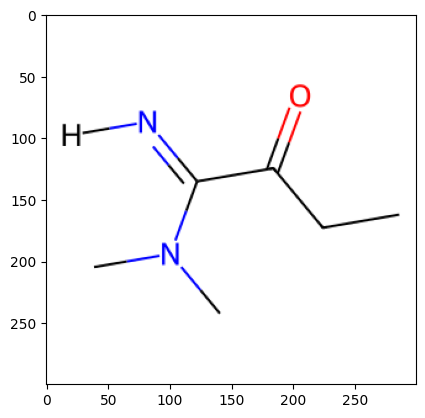

In [2]:
#!pip install --pre deepchem[torch
import deepchem as dc
import pandas as pd
import selfies as sf
import numpy as np
import torch
from rdkit import Chem
from rdkit import RDLogger  
from rdkit import Chem
RDLogger.DisableLog('rdApp.*')  # suppress error messages
import matplotlib.pyplot as plt

# Helper
def preprocess_smiles(smiles):
  return sf.encoder(smiles)  

def keys_int(symbol_to_int):
  d={}
  i=0
  for key in symbol_to_int.keys():
    d[i]=key
    i+=1
  return d

# Load Selfies dataset from QM9
def get_selfies(nb_sample = 2500):
    # Download from MolNet
    tasks, datasets, transformers = dc.molnet.load_qm9(featurizer='ECFP')
    df = pd.DataFrame(data={'smiles': datasets[0].ids})
    data = df[['smiles']].sample(nb_sample, random_state=42)
    sf.set_semantic_constraints()  # reset constraints
    constraints = sf.get_semantic_constraints()
    constraints['?'] = 3
    sf.set_semantic_constraints(constraints)
    data['selfies'] = data['smiles'].apply(preprocess_smiles)
    data['len'] = data['smiles'].apply(lambda x: len(x))
    selfies_list = np.asanyarray(data.selfies)
    return selfies_list

def selfies_to_continous_mols(selfies):
   selfies_alphabet = sf.get_alphabet_from_selfies(selfies)
   selfies_alphabet.add('[nop]')  # Add the "no operation" symbol as a padding character
   selfies_alphabet.add('.') 
   selfies_alphabet = list(sorted(selfies_alphabet))
   largest_selfie_len = max(sf.len_selfies(s) for s in selfies)
   symbol_to_int = dict((c, i) for i, c in enumerate(selfies_alphabet))
   int_mol=keys_int(symbol_to_int)
   onehots=sf.batch_selfies_to_flat_hot(selfies, symbol_to_int,largest_selfie_len)
   input_tensor = torch.tensor(onehots, dtype=torch.float32)
   noise_tensor = torch.rand(input_tensor.shape, dtype=torch.float32)
   dequantized_onehots = input_tensor + noise_tensor
   continous_mols = (dequantized_onehots - dequantized_onehots.min()) / (dequantized_onehots.max() - dequantized_onehots.min())
   return continous_mols, selfies_alphabet, largest_selfie_len, int_mol, dequantized_onehots.min(), dequantized_onehots.max()

def mols_continous_to_selfies(continous_mols, selfies_alphabet, largest_selfie_len, int_mol, dequantized_onehots_min, dequantized_onehots_max):
   denormalized_data = continous_mols * (dequantized_onehots_max - dequantized_onehots_min) + dequantized_onehots_min
   quantized_data = torch.floor(denormalized_data)
   quantized_data = torch.clip(quantized_data, 0, 1)
   mols_list = quantized_data.cpu().int().numpy().tolist()
   #print(mols_list)
   for mol in mols_list:
    for i in range(largest_selfie_len):
        row = mol[len(selfies_alphabet) * i: len(selfies_alphabet) * (i + 1)]
        if all(elem == 0 for elem in row):
            mol[len(selfies_alphabet) * (i+1) - 1] = 1
   selfies = sf.batch_flat_hot_to_selfies(mols_list, int_mol)
   return selfies

def selfies_to_mols(selfies_to_convert):
  valid_count = 0
  valid_selfies, invalid_selfies = [], []
  mols = []
  for idx, selfies in enumerate(selfies_to_convert):
    try:
      if Chem.MolFromSmiles(sf.decoder(selfies_to_convert[idx]), sanitize=True) is not None:
          valid_count += 1
          valid_selfies.append(selfies)
          mols.append(Chem.MolFromSmiles(sf.decoder(selfies_to_convert[idx])))
      else:
        invalid_selfies.append(selfies)
    except Exception:
      pass
  return mols, valid_selfies, valid_count

#Test get_selfies_list
original_selfies = get_selfies()
mol = Chem.MolFromSmiles(sf.decoder(original_selfies[3]))
mol_img = Chem.Draw.MolToImage(mol,size=(300,300))
plt.imshow(mol_img)

100.00 % of generated samples are valid molecules.


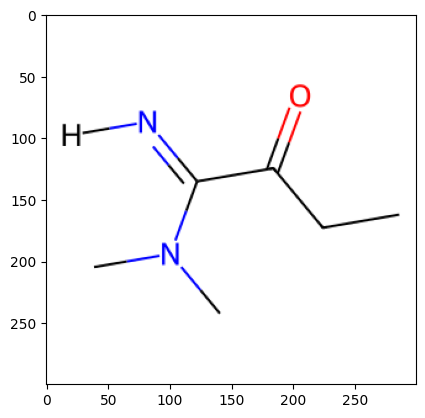

In [3]:
# Test Original Selfies -> continous_mols -> Recalculate Selfies
continous_mols, selfies_alphabet, largest_selfie_len, int_mol, dequantized_onehots_min, dequantized_onehots_max = selfies_to_continous_mols(original_selfies)
recalculate_selfies_test = mols_continous_to_selfies(continous_mols, selfies_alphabet, largest_selfie_len, int_mol, dequantized_onehots_min, dequantized_onehots_max)
mols_test, valid_selfies_list, valid_count = selfies_to_mols(recalculate_selfies_test)
print('%.2f' % (valid_count / len(mols_test)*100),  '% of generated samples are valid molecules.')

smiles_label = [Chem.MolToSmiles(mol) for mol in mols_test[:9]]
img = Chem.Draw.MolsToGridImage(mols_test[:9], molsPerRow=3, subImgSize=(200,200), returnPNG=False)
img.save('results/test-functions.png')   

mol_img = Chem.Draw.MolToImage(mols_test[3],size=(300,300))
plt.imshow(mol_img)

### Training

In [4]:
# Class of custom dataset
class Dataset1D(Dataset):
    def __init__(self, x: Tensor, y: Tensor):
        super().__init__()
        self.x = x.clone()
        self.y = y.clone()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [5]:
# load dataset 
dataset, selfies_alphabet, largest_selfie_len, int_mol, dequantized_onehots_min, dequantized_onehots_max = selfies_to_continous_mols(get_selfies())
print(dataset.shape)
seq_length = dataset.shape[1]
num_classes = 1
channels = 1
batch_size = 16

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)

torch.Size([2500, 3120])


In [6]:
save_and_sample_every = 5

In [7]:
dataset = Dataset1D(dataset[:, None, :].float(), torch.zeros(dataset.shape[0]).int())

In [8]:
# create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet1D(
    dim = 16,
    dim_mults = (1, 2, 4, 8),
    num_classes = num_classes,
    channels = channels,
    #cond_drop_prob = 0.5
    cond_drop_prob = 0.
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = seq_length,
    timesteps = 300
).to(device)

optimizer = Adam(model.parameters(), lr=1e-4)

In [10]:
from torchvision.utils import save_image

epochs = 10000

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()
      training_mols = batch[0].to(device) # normalized from 0 to 1
      mols_classes = batch[1].to(device)    # say 1 classes

      loss = diffusion(training_mols, classes = mols_classes)

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()
      
      # save generated mols
      if step == 0 and (epoch == 0 or epoch % save_and_sample_every == 0):
        try:
          nb_mols = 16
          samples_classes = torch.zeros(nb_mols).int().to(device)
          # unconditional
          all_continous_mols = torch.squeeze(diffusion.sample(samples_classes, cond_scale = 0))
          recalculate_selfies = mols_continous_to_selfies(all_continous_mols, selfies_alphabet, largest_selfie_len, int_mol, dequantized_onehots_min, dequantized_onehots_max)
          mols, valid_selfies_list, valid_count = selfies_to_mols(recalculate_selfies)
          print(valid_selfies_list)
          print('%.2f' % (valid_count / len(recalculate_selfies)*100),  '% of generated samples are valid molecules.')
          img = Chem.Draw.MolsToGridImage(mols[:9], molsPerRow=3, subImgSize=(200,200), returnPNG=False)
          img.save(str(results_folder / f'mol1D-unconditional-{epoch}-{step}.png'))
        except Exception:
          pass  
        #print(recalculate_selfies[1])
      #  save_image(all_images.view(all_images.shape[0],all_images.shape[1],32,32), str(results_folder / f'test1D1000-unconditional-{epoch}-{step}.png'), nrow = 6)
        # conditionnal
      #  all_images = diffusion.sample(images_classes, cond_scale = 6.)     
      #  save_image(all_images.view(all_images.shape[0],all_images.shape[1],32,32), str(results_folder / f'test1D1000-conditionnal-{epoch}-{step}.png'), nrow = 6)

Loss: 1.3625743389129639


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

['[#Branch1]..[#N][#Branch1].[#Branch1].[#Branch1][#C][#Branch2][#N][#Branch2][#C].[#Branch1][#C].[#Branch2][#Branch1].[#Branch1]...[#Branch2].[#C][#Branch1][#Branch2][#Branch1][#Branch1][#Branch1][#Branch1][#C].[#C]..[#Branch1].[#Branch2][#Branch2].....[#Branch1][#Branch1][#Branch1].[#Branch2][#Branch1].[#Branch2][#Branch1]....[#Branch1][#Branch1][#N][#C]', '[#Branch2].....[#Branch1].[#Branch2].[#Branch1].[#C]..[#Branch2]..[#C]..[#Branch1][#Branch1][#Branch1].[#C][#Branch2][#Branch1].[#Branch1][#Branch1][#Branch1][#C][#Branch1].[#Branch1]..[#Branch1][#C].[#Branch1].[#Branch1].[#N][#Branch2].[#Branch1][/C][#Branch1][#N][#N].[#N]..[#Branch1][/N][#Branch2]..[#Branch1][#Branch1][/H]', '..[#Branch2][#Branch1].[#C].[#Branch2]...[#C]..[#Branch1]..[#C][#Branch1][#C][#C].[#Branch1][#Branch1][#Branch1][#C][#Branch2][#Branch2][#C]..[#C].[#Branch2]..[#Branch1][#Branch1][#C][#Branch2].[#C].[#C]...[#Branch1][#Branch1].[#Branch2][#Branch1][#Branch2][#Branch2][-\\Ring2]..[#C][#Branch2].[#Branch1][#Br

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

['.................................................................', '[#Branch1]................................................................', '[#Branch1]................................................................', '.................................................................', '[#Branch1]................................................................', '[#Branch1]................................................................', '.................................................................', '[#Branch1]................................................................', '[#Branch1]................................................................', '[#Branch1]................................................................', '.................................................................', '.................................................................', '.................................................................', '......................................

KeyboardInterrupt: 

In [ ]:
sampled_images = diffusion.sample(
    classes = image_classes,
    cond_scale = 6.                # condition scaling, anything greater than 1 strengthens the classifier free guidance. reportedly 3-8 is good empirically
)

sampled_images.shape # (8, 3, 128, 128)

# interpolation

interpolate_out = diffusion.interpolate(
    training_images[:1],
    training_images[:1],
    image_classes[:1]
)